## Data Cleaning Analysis

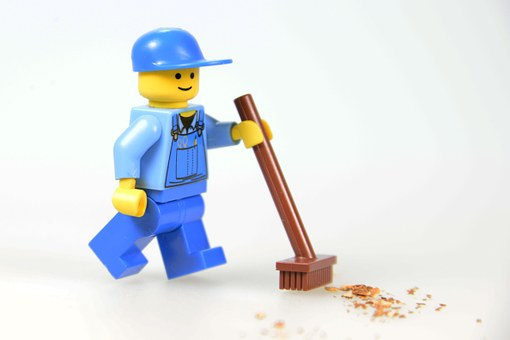

### Results-Summary:

**Outliers:**
- Year_Birth < 1940
- Income == 600k (24 missing values -> impute with median)
- 210 < Sweets
- 1250 < Meat
- 250 < Gold
- "NumWebPurchases" > 11 -> 11
- NumCatalogPurchases > 11 -> 11
- NumWebVisitsMonth > 9 -> 9


**Anomalies:**
- marital status: YOLO, Absurd (remove) Alone to Single
- Complain has no explanatory power

**Feature Engineering Ideas:**
- Partner (binary column from marital status)
- Campaing responsiveness (sum of all campaigns divided by 5)

**Other:**
- tendency to respond for people who buy wine
- tendency to respond for people who bought recently (-> These features should be included in the models)


In [67]:
from utils import *
import seaborn as sns
import preprocessing
import feature_engineering

In [2]:
data = get_dataset()

In [3]:
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [ ]:
# encode days as customer, otherwise the column doesn't make sense
data = preprocessing.encode_days_as_costumer(data)

### Missings

In [5]:
def missing_values_reporter(df):    
    na_count = df.isna().sum() 
    ser = na_count[na_count > 0]
    return pd.DataFrame({"N missings": ser, "% missings": ser.divide(df.shape[0])})

df_miss=missing_values_reporter(data)
df_miss

,N missings,% missings
Income,24,0.010714


From the missing data perspective it looks pretty neat.

### Categoricals

In [47]:
data.describe(include=["object", "category"])

,Education,Marital_Status,Dt_Customer
count,2240,2240,2240
unique,5,8,663
top,Graduation,Married,2012-08-31
freq,1127,864,12


In [7]:
data["Education"].unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

In [9]:
data["Marital_Status"].unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

Weird statusses for marital: Absurd, Yolo

In [12]:
data.loc[data["Marital_Status"] == "Absurd", :]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
2093,7734,1993,Graduation,Absurd,79244.0,0,0,2012-12-19,58,471,...,1,0,0,1,1,0,0,3,11,1
2134,4369,1957,Master,Absurd,65487.0,0,0,2014-01-10,48,240,...,2,0,0,0,0,0,0,3,11,0


In [13]:
data.loc[data["Marital_Status"] == "YOLO", :]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
2177,492,1973,PhD,YOLO,48432.0,0,1,2012-10-18,3,322,...,8,0,0,0,0,0,0,3,11,0
2202,11133,1973,PhD,YOLO,48432.0,0,1,2012-10-18,3,322,...,8,0,0,0,0,0,0,3,11,1


Both should be removed.

As a next step let's take a closer look on the features provided.

In [14]:
data.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

The data can be grouped into socio-economic, buying behaviour, purchase behaviour and campaign behaviour.

In [15]:
socio = ['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer']

In [25]:
buying = ['Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds']

In [17]:
purchase = ['NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

In [18]:
campaign = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain']

Now we'll go through each category individually and check what can be retrieved from it.

### Socio Features

In [ ]:
socio = ['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer']

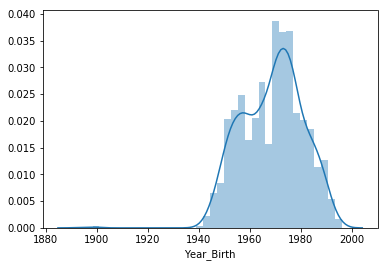

In [98]:
#looks like there are instances older than 1940
sns.distplot(data["Year_Birth"])

In [101]:
# 3 instances of people older than 100 years -> very unlikely
data.loc[data["Year_Birth"]<1940, :]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
192,1900,2n Cycle,Divorced,36640.0,1,0,276,99,15,6,...,1,2,5,0,0,0,0,0,1,0
239,1893,2n Cycle,Single,60182.0,0,1,43,23,8,0,...,0,2,4,0,0,0,0,0,0,0
339,1899,PhD,Together,83532.0,0,0,276,36,755,144,...,6,4,1,0,0,1,0,0,0,0


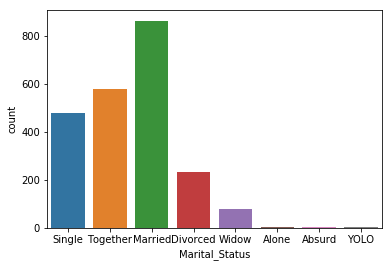

In [103]:
# Alone should be put into single
# Idea for feature engineering -> people with partner or no partner (binary)
sns.countplot(x="Marital_Status", data=data)

In [105]:
# drop the missings from income
temp_df = data.dropna()

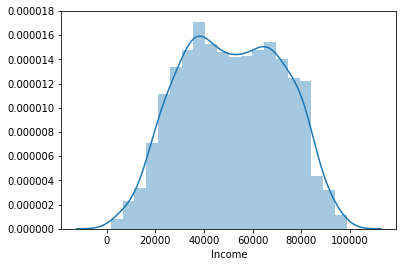

In [110]:
# some huge outliers
sns.distplot(temp_df.loc[temp_df["Income"]<100000, "Income"])

In [109]:
# except one guy with 600k these data seem legit
# I would impute the missing values with the median
data.loc[data["Income"]>100000, :]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
124,1983,Graduation,Single,101970.0,0,0,474,69,722,27,...,8,13,2,0,1,1,1,0,0,1
164,1973,PhD,Married,157243.0,0,1,120,98,20,2,...,22,0,0,0,0,0,0,0,0,0
203,1977,PhD,Together,102160.0,0,0,604,54,763,29,...,9,10,4,0,1,1,1,0,0,1
252,1974,Graduation,Divorced,102692.0,0,0,450,5,168,148,...,9,13,2,0,1,1,1,1,0,1
617,1976,PhD,Together,162397.0,1,1,391,31,85,1,...,0,1,1,0,0,0,0,0,0,0
646,1970,Graduation,Together,105471.0,0,0,524,36,1009,181,...,8,13,3,0,0,1,1,0,0,1
655,1975,Graduation,Divorced,153924.0,0,0,142,81,1,1,...,0,0,0,0,0,0,0,0,0,0
687,1982,PhD,Married,160803.0,0,0,694,21,55,16,...,28,1,0,0,0,0,0,0,0,0
1300,1971,Master,Together,157733.0,1,0,390,37,39,1,...,0,1,1,0,0,0,0,0,0,0
1653,1977,Graduation,Together,157146.0,0,0,426,13,1,0,...,28,0,1,0,0,0,0,0,0,0


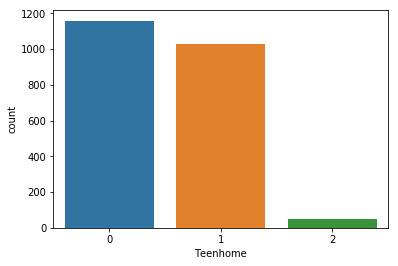

In [113]:
sns.countplot(x="Teenhome", data=data)

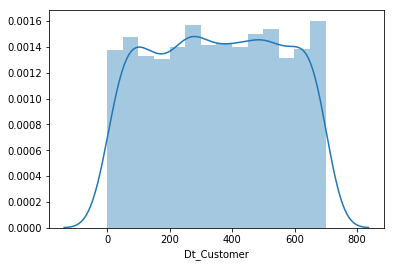

In [116]:
sns.distplot(data["Dt_Customer"])

#### Result for Socio Features:
- Year_Birth < 1940 should be removed
- Marital_Status Absurd and YOLO should be removed, Alone should be changed to single
- missing income should be imputed with the median as well as the guy with 600k income

### Buying behaviour

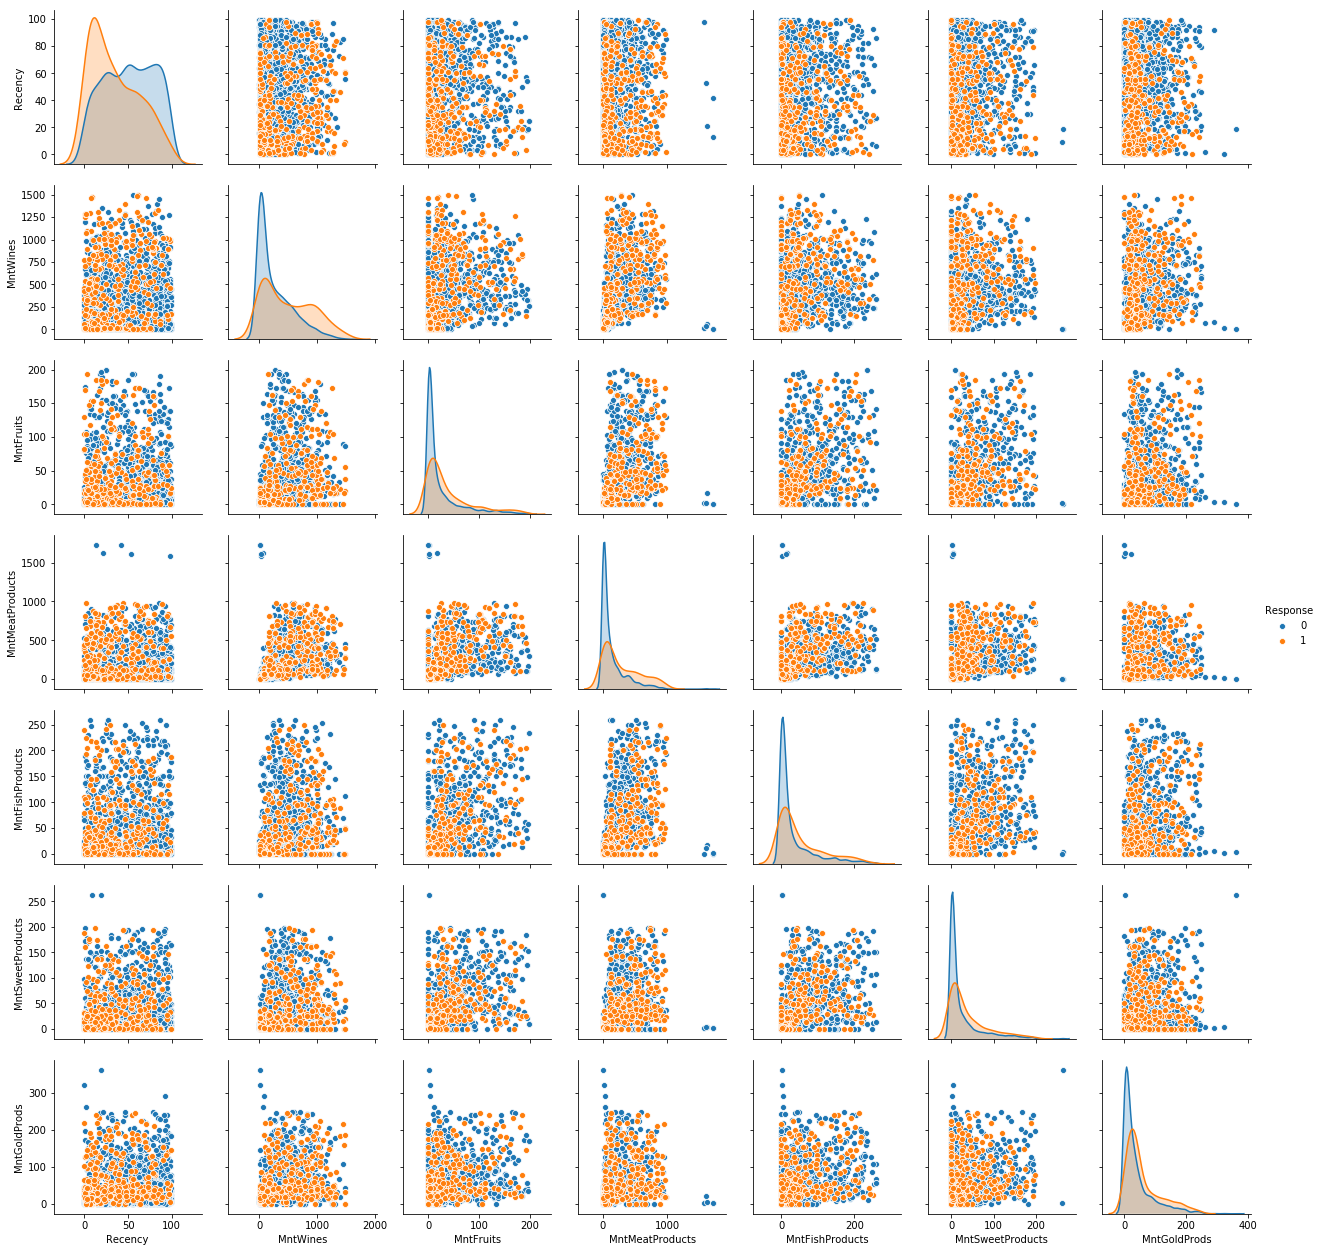

In [26]:
sns.pairplot(data, hue= "Response", vars=buying)

From the plot one could see, that there are a couple of outliers in MntGoldProds, MntMeatProds, MntSweetProds.

Also what could be seen is, that people who buy more wine have a slight tendency to respond more often. Also people who bought stuff more recently show a similar tendency. Apart from that, there's not much more.

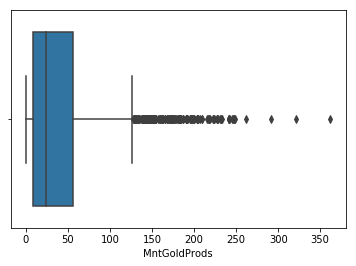

In [64]:
# cutoff at 250
sns.boxplot(x=data["MntGoldProds"])

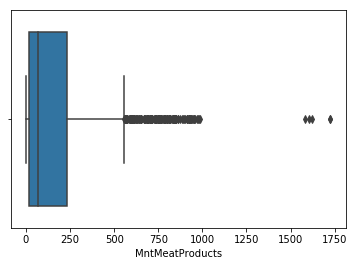

In [60]:
# cutoff at 1250
sns.boxplot(x=data["MntMeatProducts"])

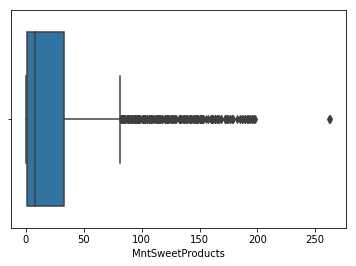

In [62]:
# cutoff at 210
sns.boxplot(x=data["MntSweetProducts"])

#### Result for Buying Behavior:
- tendency to respond for people who buy wine
- tendency to respond for people who bought recently (-> **These features should be included in the models**)

- outlier cutoff: 210 for Sweets, 1250 for Meat, 250 for Gold

### Purchase Behaviour

In [ ]:
purchase = ['NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

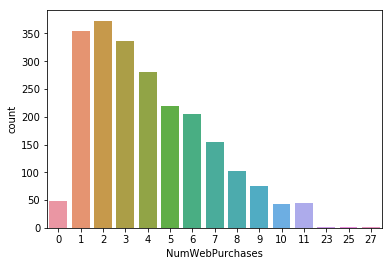

In [70]:
# possibly remove 23,25 and 27 as they seem far off and are not consecutive
sns.countplot(data["NumWebPurchases"])

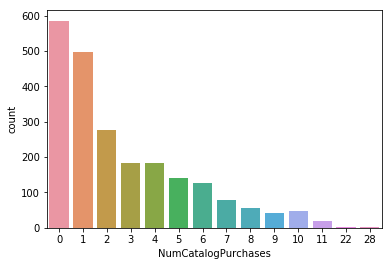

In [71]:
# possibly remove 22 and 28 as they seem far off and are not consecutive
sns.countplot(data["NumCatalogPurchases"])

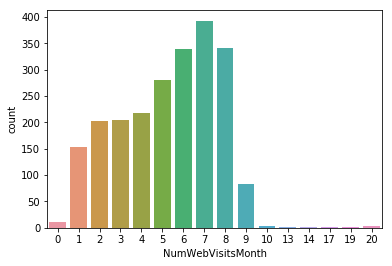

In [73]:
# possibly remove 13 and higher
sns.countplot(data["NumWebVisitsMonth"])

#### Result for Purchase Behavior:
- Web and Catalog purchases as well as Web visits seem to have some outlier values. Nevertheless I wouldn't consider them errornous and suggest to change these values to the highest category (e.g. Web Visits > 9 will be put into class 9)

### Campaigning Behaviour

In [ ]:
campaign = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain']

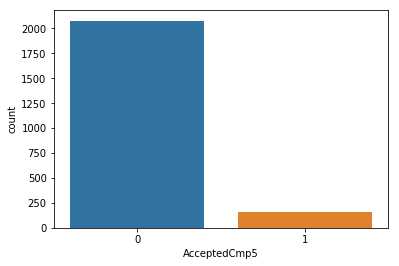

In [90]:
sns.countplot(x="AcceptedCmp5", data=data)

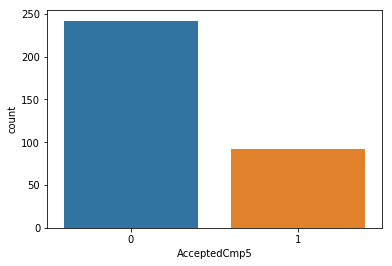

In [89]:
sns.countplot(x="AcceptedCmp5", data=data.loc[data["Response"]==1, :])

Even though the Campaign column is also very imbalanced I would keep all of them as they seem to have some discrimination ability. For instance, whoever responded to campaign 5 has also a tendency to respond to the current campaign.

Possible idea for feature engineering: column for *Responsiveness*, meaning the sum of all responses divided by 5.

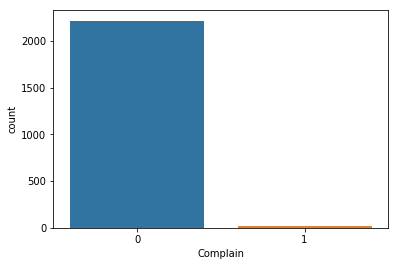

In [91]:
# I would remove Complain column
sns.countplot(data["Complain"])

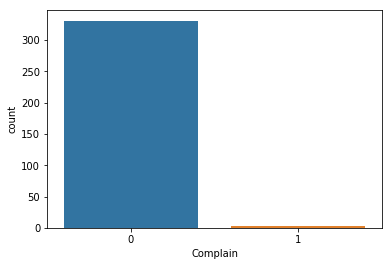

In [92]:
sns.countplot(x="Complain", data=data.loc[data["Response"]==1, :])

I would completely neglect the complain column it doesn't seem to have much explanatory power.

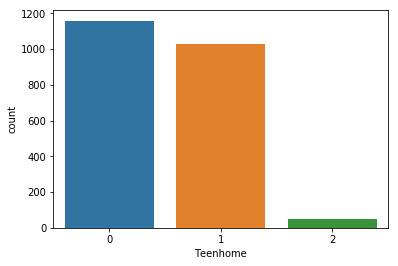

In [40]:
sns.countplot(data["Teenhome"])

In [35]:
data.loc[data["Complain"]==1,:]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
78,10401,1976,2n Cycle,Together,26326.0,0,0,2013-09-04,12,1,...,3,0,0,0,0,0,1,3,11,0
147,3120,1981,Graduation,Together,38547.0,1,0,2013-08-28,49,6,...,8,0,0,0,0,0,1,3,11,0
192,7829,1900,2n Cycle,Divorced,36640.0,1,0,2013-09-26,99,15,...,5,0,0,0,0,0,1,3,11,0
271,5726,1983,Master,Single,31788.0,1,0,2014-03-20,15,16,...,5,0,0,0,0,0,1,3,11,0
355,6201,1978,Graduation,Single,38643.0,1,1,2013-11-29,45,22,...,7,0,0,0,0,0,1,3,11,0
358,6142,1943,Master,Married,65073.0,0,0,2013-08-20,65,629,...,2,0,0,0,0,0,1,3,11,0
590,3710,1984,PhD,Single,39684.0,1,0,2012-10-12,41,19,...,7,0,0,0,0,0,1,3,11,1
972,10995,1988,2n Cycle,Married,15716.0,1,0,2012-11-12,8,16,...,8,0,0,0,0,0,1,3,11,0
1041,6730,1954,Graduation,Married,38998.0,1,1,2012-11-03,92,34,...,8,0,0,0,0,0,1,3,11,0
1069,2875,1978,Graduation,Married,67023.0,0,0,2014-03-04,93,444,...,2,0,0,0,0,0,1,3,11,0
